In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
df = pd.read_csv("sales_5000000.csv")
df = df[['Order Date', 'Total Profit']] 
df['Order Date'] = pd.to_datetime(df['Order Date'])
daily_df = df.groupby('Order Date')['Total Profit'].sum().reset_index()
weekly_df = daily_df.resample('W', on='Order Date')['Total Profit'].sum().reset_index()
weekly_df.columns = ['Order Date', 'Total Profit']
weekly_df.set_index('Order Date', inplace=True)

In [3]:
weekly_df

,Total Profit
Order Date,
2014-01-05,2.469979e+09
2014-01-12,3.534829e+09
2014-01-19,3.490367e+09
2014-01-26,3.531767e+09
2014-02-02,3.531567e+09
...,...
2024-08-18,3.546312e+09
2024-08-25,3.487374e+09
2024-09-01,3.483251e+09


<Axes: >

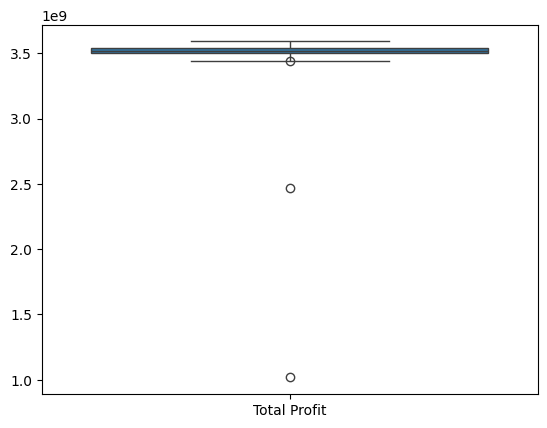

In [4]:
sns.boxplot(weekly_df)

In [5]:
Q1 = weekly_df['Total Profit'].quantile(0.25)
Q3 = weekly_df['Total Profit'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

weekly_df = weekly_df[
    (weekly_df['Total Profit'] >= lower_bound) & 
    (weekly_df['Total Profit'] <= upper_bound)
]

<Axes: >

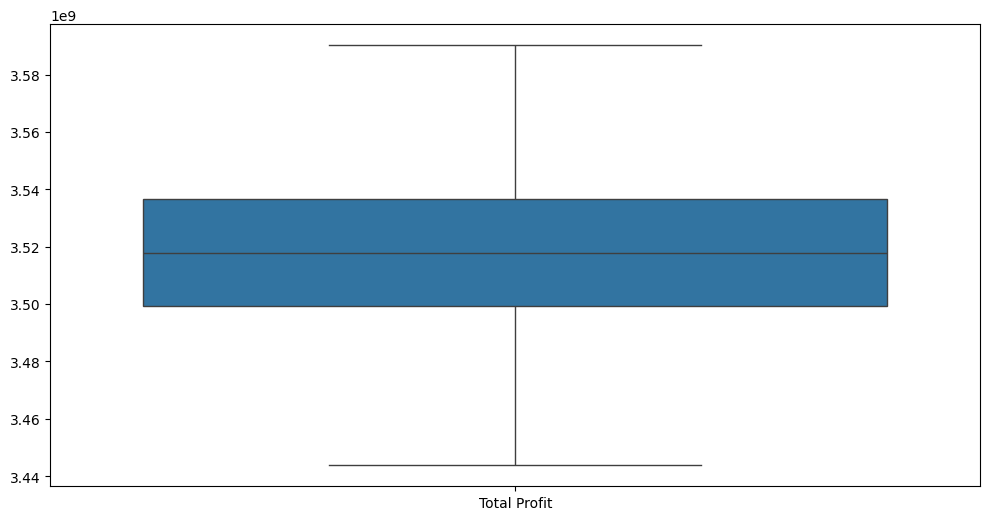

In [6]:
plt.figure(figsize=(12,6))
sns.boxplot(weekly_df)

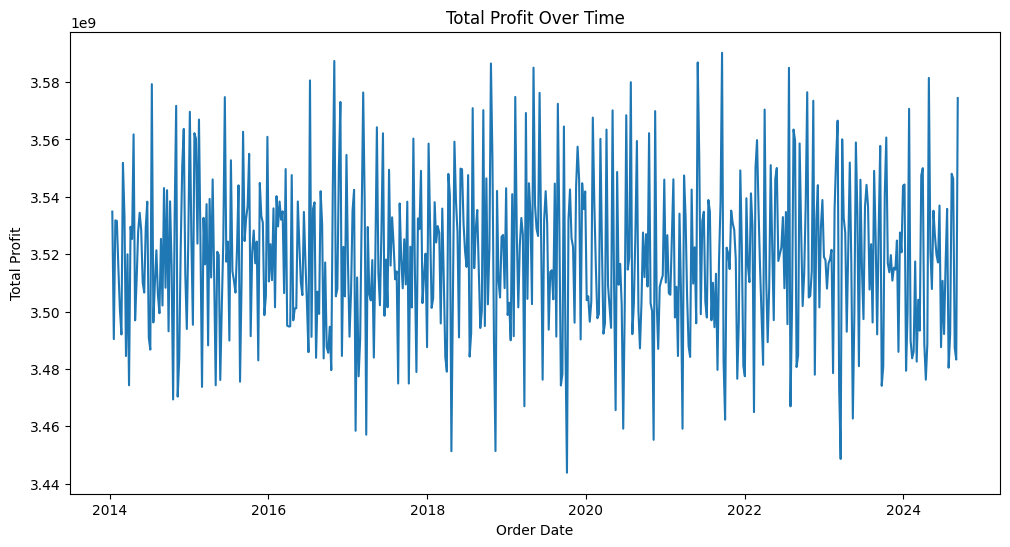

In [7]:
plt.figure(figsize=(12,6))
plt.plot(weekly_df)
plt.xlabel('Order Date')
plt.ylabel('Total Profit')
plt.title('Total Profit Over Time')
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, series is stationary")
    else:
        print("Weak evidence against null hypothesis, series is non-stationary")

print("ADF Test for Original Series:")
adf_test(weekly_df['Total Profit'])

ADF Test for Original Series:
ADF Statistic: -5.127233798624824
p-value: 1.2354920147311377e-05
Critical Values:
   1%: -3.4425861905056556
   5%: -2.8669372502674824
   10%: -2.5696445454608505
Strong evidence against the null hypothesis, series is stationary


In [9]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    result = kpss(series)
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, series is non-stationary")
    else:
        print("Weak evidence against null hypothesis, series is stationary")

print("\nKPSS Test for Original Series:")
kpss_test(weekly_df['Total Profit'])


KPSS Test for Original Series:
KPSS Statistic: 0.07834805066727762
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Weak evidence against null hypothesis, series is stationary


C:\Users\Sailesh\AppData\Local\Temp\ipykernel_4104\1050917048.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)


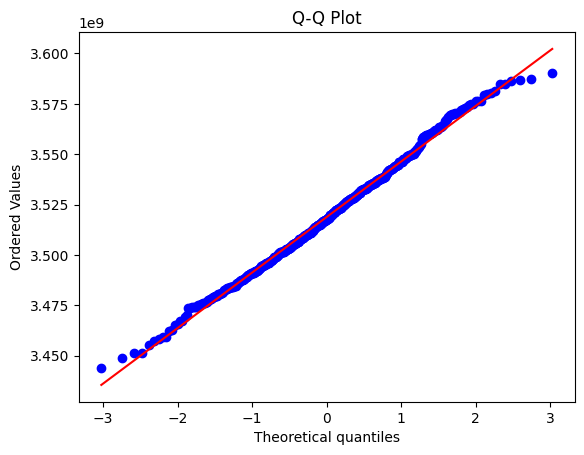

In [10]:
import scipy.stats as stats

stats.probplot(weekly_df['Total Profit'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

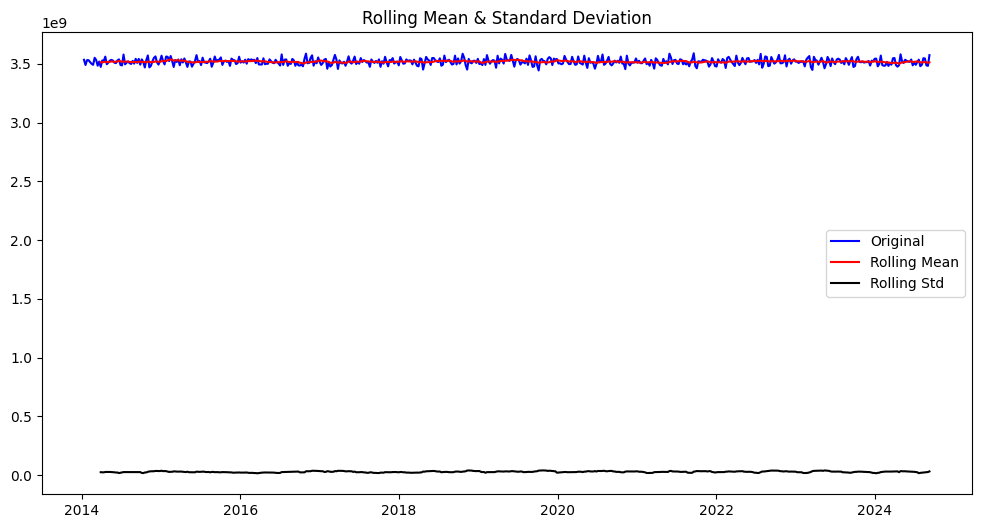

In [11]:
rolling_mean = weekly_df['Total Profit'].rolling(window=12).mean()
rolling_std = weekly_df['Total Profit'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(weekly_df['Total Profit'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

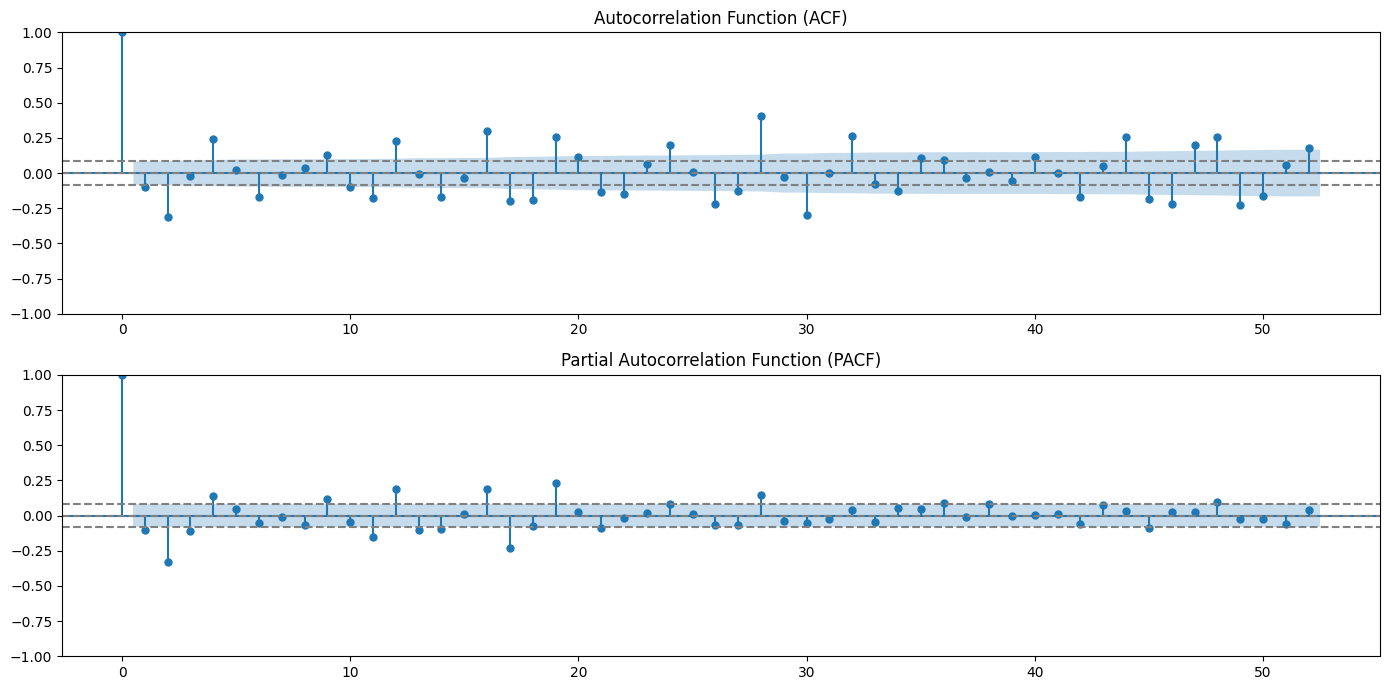

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(14, 7))

# ACF Plot
plt.subplot(2, 1, 1)
plot_acf(weekly_df['Total Profit'], lags=52, ax=plt.gca(), 
         title='Autocorrelation Function (ACF)')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(weekly_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(weekly_df)), linestyle='--', color='gray')

# PACF Plot
plt.subplot(2, 1, 2)
plot_pacf(weekly_df['Total Profit'], lags=52, ax=plt.gca(), 
          title='Partial Autocorrelation Function (PACF)', method='ywm')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(weekly_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(weekly_df)), linestyle='--', color='gray')

plt.tight_layout()
plt.show()

In [13]:
train_data, test_data = train_test_split(weekly_df, test_size=0.2, shuffle=False)

In [14]:
scaler = MinMaxScaler()
train_data["Total Profit"] = scaler.fit_transform(train_data[["Total Profit"]])
test_data["Total Profit"] = scaler.transform(test_data[["Total Profit"]])

In [15]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12

values_train = train_data["Total Profit"].values
values_test = test_data["Total Profit"].values

X_train, y_train = create_sequences(values_train, seq_length)
X_test, y_test = create_sequences(values_test, seq_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [16]:
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(seq_length, 1)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(100, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(50)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

model.compile(optimizer='adam', loss=rmse, metrics=['mae', rmse])

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
27/27 [==============================] - 9s 78ms/step - loss: 1.0389 - mae: 0.8415 - rmse: 1.0389 - val_loss: 0.5824 - val_mae: 0.5506 - val_rmse: 0.5888
Epoch 2/50
27/27 [==============================] - 1s 22ms/step - loss: 0.7463 - mae: 0.6111 - rmse: 0.7463 - val_loss: 0.5734 - val_mae: 0.5413 - val_rmse: 0.5789
Epoch 3/50
27/27 [==============================] - 1s 21ms/step - loss: 0.6087 - mae: 0.4818 - rmse: 0.6087 - val_loss: 0.5557 - val_mae: 0.5226 - val_rmse: 0.5622
Epoch 4/50
27/27 [==============================] - 1s 21ms/step - loss: 0.5532 - mae: 0.4517 - rmse: 0.5532 - val_loss: 0.5193 - val_mae: 0.4843 - val_rmse: 0.5248
Epoch 5/50
27/27 [==============================] - 1s 23ms/step - loss: 0.4523 - mae: 0.3574 - rmse: 0.4523 - val_loss: 0.4852 - val_mae: 0.4470 - val_rmse: 0.4892
Epoch 6/50
27/27 [==============================] - 1s 22ms/step - loss: 0.4378 - mae: 0.3494 - rmse: 0.4378 - val_loss: 0.3785 - val_mae: 0.3309 - val_rmse: 0.3827
Epoch 7/50

4/4 [==============================] - 1s 9ms/step
MAPA (Accuracy): 99.31%


Text(0.5, 1.0, 'Actual vs Predicted Total Profit')

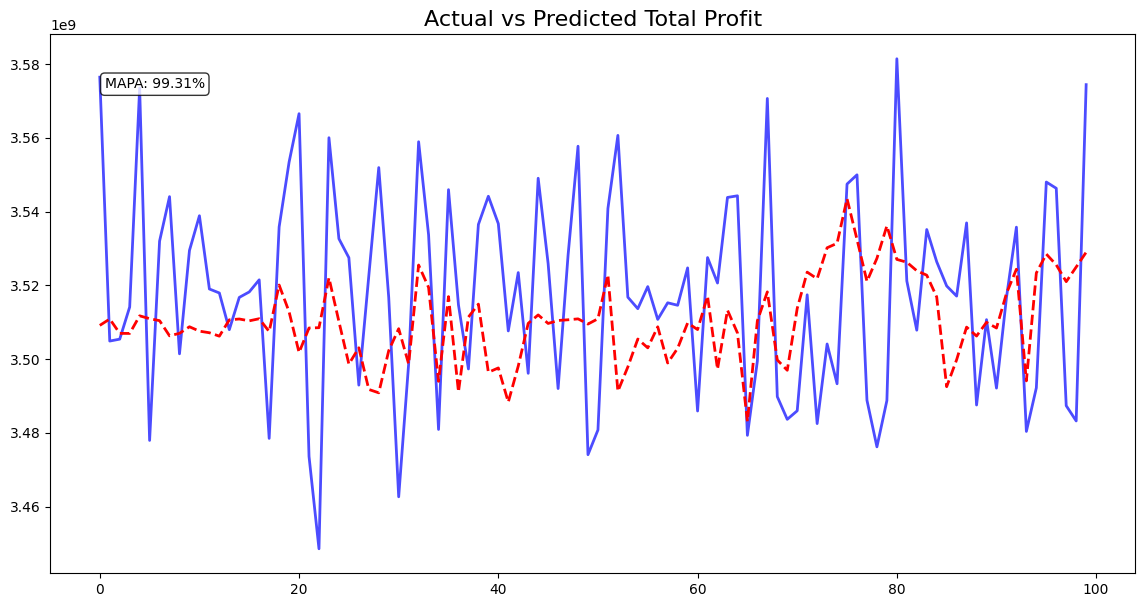

In [17]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
mapa = (1 - mape / 100) * 100
print(f"MAPA (Accuracy): {mapa:.2f}%")

plt.figure(figsize=(14, 7))

plt.plot(y_test_inv, 'b-', linewidth=2, label='Actual Values', alpha=0.7)

plt.plot(y_pred_inv, 'r--', linewidth=2, label='Predicted Values')

plt.annotate(f'MAPA: {mapa:.2f}%', 
             xy=(0.05, 0.9), xycoords='axes fraction',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize plot
plt.title('Actual vs Predicted Total Profit', fontsize=16)

14/14 [==============================] - 0s 9ms/step
MAPA (Accuracy): 99.37%


Text(0.5, 1.0, 'Actual vs Predicted Total Profit')

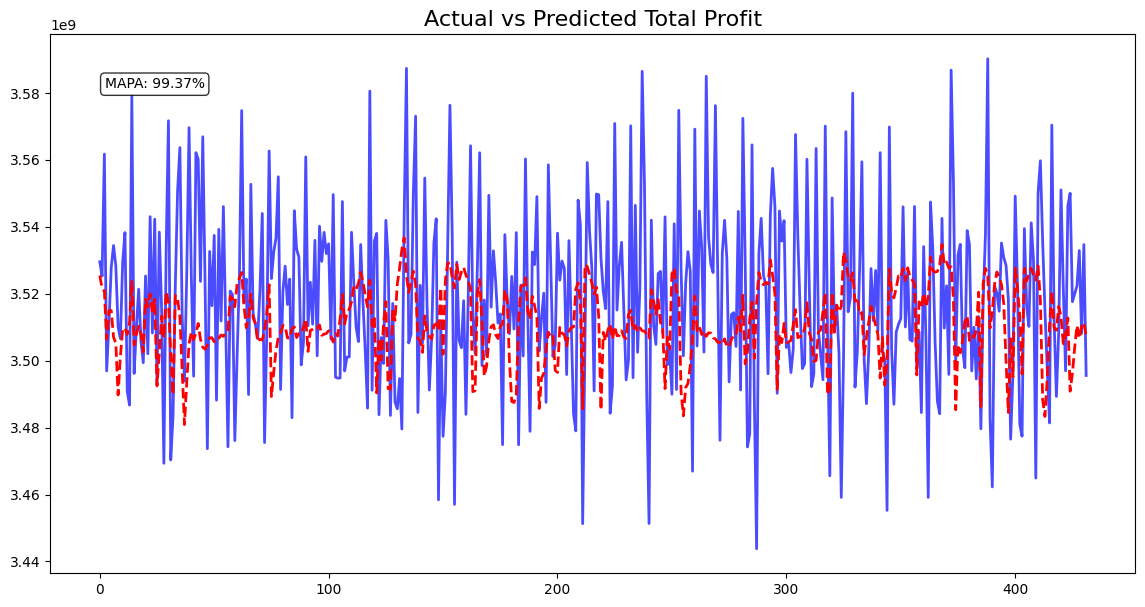

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

y_pred = model.predict(X_train)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

mape = mean_absolute_percentage_error(y_train_inv, y_pred_inv) * 100
mapa = (1 - mape / 100) * 100
print(f"MAPA (Accuracy): {mapa:.2f}%")

plt.figure(figsize=(14, 7))

plt.plot(y_train_inv, 'b-', linewidth=2, label='Actual Values', alpha=0.7)

plt.plot(y_pred_inv, 'r--', linewidth=2, label='Predicted Values')

plt.annotate(f'MAPA: {mapa:.2f}%', 
             xy=(0.05, 0.9), xycoords='axes fraction',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize plot
plt.title('Actual vs Predicted Total Profit', fontsize=16)

In [31]:
future_df = weekly_df.copy()

future_df.index = future_df.index + pd.DateOffset(years=10)

future_df_scaled = scaler.transform(future_df[["Total Profit"]])

X_future, _ = create_sequences(future_df_scaled.flatten(), seq_length)
X_future = X_future.reshape((X_future.shape[0], X_future.shape[1], 1))

y_future_pred = model.predict(X_future)
y_future_pred_inv = scaler.inverse_transform(y_future_pred)


17/17 [==============================] - 0s 14ms/step


In [36]:
future_df.index

DatetimeIndex(['2024-01-12', '2024-01-19', '2024-01-26', '2024-02-02',
               '2024-02-09', '2024-02-16', '2024-02-23', '2024-03-02',
               '2024-03-09', '2024-03-16',
               ...
               '2034-07-07', '2034-07-14', '2034-07-21', '2034-07-28',
               '2034-08-04', '2034-08-11', '2034-08-18', '2034-08-25',
               '2034-09-01', '2034-09-08'],
              dtype='datetime64[ns]', name='Order Date', length=556, freq=None)

Text(0.5, 1.0, 'Actual vs Predicted Total Profit')

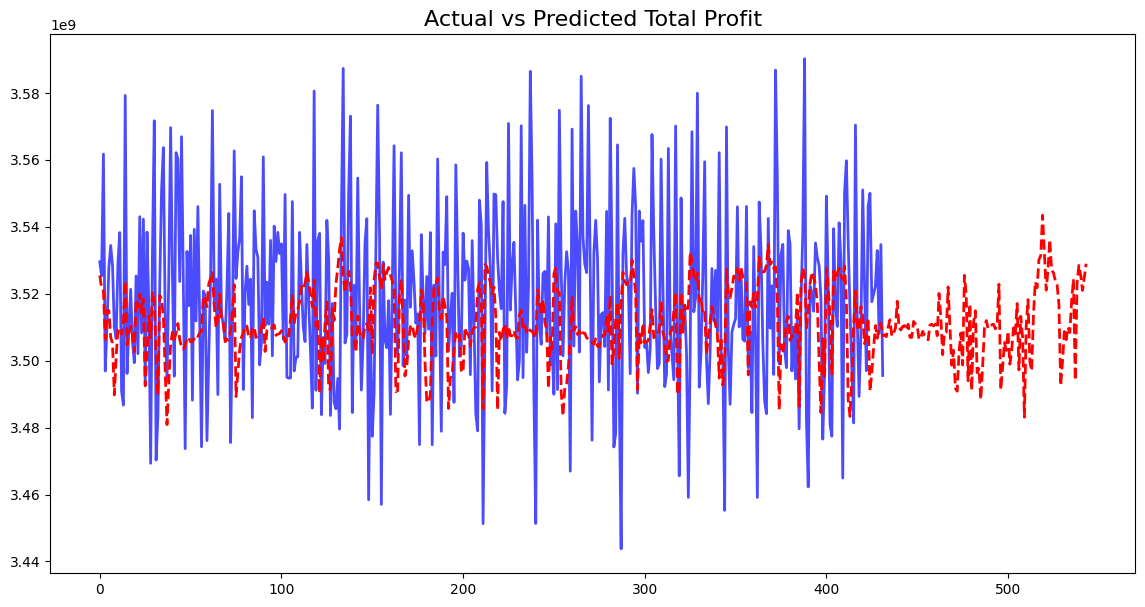

In [32]:
plt.figure(figsize=(14, 7))

plt.plot(y_train_inv, 'b-', linewidth=2, label='Actual Values', alpha=0.7)

plt.plot(future_df.index, y_future_pred_inv, 'r--', linewidth=2, label='Predicted Values')
plt.title('Actual vs Predicted Total Profit', fontsize=16)

In [ ]:
y_future_pred = model.predict(X_future_test)

In [ ]:
y_future_pred = model.predict(X_test)

In [ ]:
y_future_pred

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
mapa = (1 - mape / 100) * 100

plt.figure(figsize=(14, 7))

plt.plot(y_test_inv, 'b-', linewidth=2, label='Actual Values', alpha=0.7)

plt.plot(y_future_pred, 'r--', linewidth=2, label='Predicted Values')

plt.annotate(f'MAPA: {mapa:.2f}%', 
             xy=(0.05, 0.9), xycoords='axes fraction',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('Actual vs Predicted Total Profit', fontsize=16)